# DETECTION DE FRAUDES__TEST HYPEROPT 

Dans ce notebook nous allons essayer d'améliorer nos modèles en faisant différents tests et en utilisant hyperopt pour le tunning

**Problématique: developper un modèle de classification binaire de machine learning pour prédire si une transaction bancaire est une fraude ou non**

### import/preprocessing/definition des fonctions

In [11]:
from IPython.display import Image
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer,LabelEncoder,RobustScaler,PolynomialFeatures
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,ConfusionMatrixDisplay,precision_score,precision_recall_fscore_support,plot_precision_recall_curve,roc_curve,roc_auc_score,recall_score,f1_score,make_scorer,SCORERS,plot_roc_curve,roc_curve
from sklearn.tree import DecisionTreeClassifier,export_graphviz,plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import learning_curve,cross_val_score,cross_validate
from sklearn.compose import make_column_transformer
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NearMiss 
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN,SMOTETomek 
import pickle
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,IsolationForest,ExtraTreesClassifier
from sklearn.decomposition import PCA
import graphviz
from xgboost import XGBClassifier
import warnings
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold


from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope


In [13]:
os.chdir('C:\\Users\\USER\\jupyter codes')
fraudes=pd.read_csv('fraudes_bancaires.csv')
fraudes.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [14]:
#sans smote
with open('X_train1', 'rb') as f9:
    X_train1 = pickle.load(f9)
with open('y_train1', 'rb') as f10:
    y_train1 = pickle.load(f10)
with open('X_test1', 'rb') as f11:
    X_test1 = pickle.load(f11)
with open('y_test1', 'rb') as f12:
    y_test1 = pickle.load(f12)

#smote simple
with open('X_res_train', 'rb') as f13:
    X_res_train = pickle.load(f13)
with open('y_res_train', 'rb') as f14:
    y_res_train = pickle.load(f14)
with open('X_test4', 'rb') as f15:
    X_test4 = pickle.load(f15)
with open('y_test4', 'rb') as f16:
    y_test4 = pickle.load(f16)

# smote_ENN   
with open('X_res_train2', 'rb') as f1:
    X_res_train2 = pickle.load(f1)
with open('y_res_train2', 'rb') as f2:
    y_res_train2 = pickle.load(f2)
with open('X_test5', 'rb') as f3:
    X_test5 = pickle.load(f3)
with open('y_test5', 'rb') as f4:
    y_test5 = pickle.load(f4)

#smote_Tomek    
with open('X_res_train3', 'rb') as f5:
    X_res_train3 = pickle.load(f5)
with open('y_res_train3', 'rb') as f6:
    y_res_train3 = pickle.load(f6)
with open('X_test6', 'rb') as f7:
    X_test6 = pickle.load(f7)
with open('y_test6', 'rb') as f8:
    y_test6 = pickle.load(f8)

FileNotFoundError: [Errno 2] No such file or directory: 'X_train1'

In [4]:
def encoder(df):
    encodeur=LabelEncoder()
    df['is_Cash_OUT']=encodeur.fit_transform(df['type'])
    df=df.drop('type',axis=1)
    return df
def enlever_colonnes(df):
    heures=df.step %24
    df['heures']=heures
    df.drop(['nameOrig','newbalanceOrig','newbalanceDest','isFlaggedFraud','step','nameDest'],axis=1, inplace=True)
    return df
def retirer_transactions(df):
    fraudes_type=((fraudes['type']=='TRANSFER') |(fraudes['type']=='CASH_OUT'))
    index_transfert=fraudes_type[fraudes_type==True].index
    return fraudes.loc[index_transfert,:]
def scaler(df):
    scaler=RobustScaler()
    df_continue=scaler.fit_transform(df.loc[:,['amount','oldbalanceOrg','oldbalanceDest','heures']])
    df['amount']=df_continue[:,0]
    df['oldbalanceOrg']=df_continue[:,1]
    df['oldbalanceDest']=df_continue[:,2]
    df['heures']=df_continue[:,3]
    return df
def test_model(modele,X_train,X_test,y_train,y_test):
    modele.fit(X_train,y_train)
    plot_confusion_matrix(modele,X_test,y_test)

def métriques(predictions_simple,y_test1):
    print('f1 score=',f1_score(y_test1,predictions_simple))
    print('precision=',precision_score(y_test1,predictions_simple))
    print('recall=',recall_score(y_test1,predictions_simple))   

In [5]:
arbre=DecisionTreeClassifier(random_state=0)
sgd=SGDClassifier(random_state=0)
logistique=LogisticRegression(random_state=0)
voisins=KNeighborsClassifier()
svc=svm.SVC(random_state=0)
gradientboosting=GradientBoostingClassifier(random_state=0)
ADAboost=AdaBoostClassifier(random_state=0)
randomforest = RandomForestClassifier(random_state=0)
isolationforest=IsolationForest(random_state=0)
xgb=XGBClassifier(max_depth=40,random_state=0)
extreme_tree=ExtraTreesClassifier(random_state=0)
cad=CatBoostClassifier(random_state=0)

randomforest_modifié1=RandomForestClassifier(max_depth= 30, min_samples_leaf= 5,random_state=0)
randomforest_modifié2=RandomForestClassifier(max_depth= 15, min_samples_leaf= 3,random_state=0)

## Test HYPEROPT sur un arbre de décision

on va comparer le randomsearchCV avec Hyperopt pour évaluer l'éfficacité de ce dernier

#### RandomizedSearchCV sur un arbre de decision

Créons une grille aléatoire sur trois hyperparamètres et 100 tests.

On fera ensuite de même avec hyperopt

In [6]:
tree=DecisionTreeClassifier()
param_distribution={'max_depth':np.arange(1,15,1),'min_samples_leaf':np.arange(2,32,3),'min_samples_split':np.arange(2,32,3)}
random_grid=RandomizedSearchCV(tree,param_distribution,n_iter=100,cv=3,verbose=3,scoring="roc_auc")
random_grid

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'min_samples_leaf': array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29]),
                                        'min_samples_split': array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29])},
                   scoring='roc_auc', verbose=3)

On optimise trois parametres: max_depth,min_samples_leaf,min_samples_split en testant 500 modèles avec des configurations différentes (+ cv=3)

In [ ]:
random_grid.fit(X_train1,y_train1)

In [19]:
data=pd.DataFrame(random_grid.cv_results_)
data

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,23.254070,0.809790,0.427243,0.015373,14,11,13,"{'min_samples_split': 14, 'min_samples_leaf': ...",0.979503,0.972468,0.974716,0.975562,0.002934,38
1,6.247398,0.090585,0.403327,0.052745,11,20,3,"{'min_samples_split': 11, 'min_samples_leaf': ...",0.854133,0.782632,0.769760,0.802175,0.037114,84
2,15.683951,0.272385,0.446147,0.007060,23,29,8,"{'min_samples_split': 23, 'min_samples_leaf': ...",0.981988,0.967580,0.975702,0.975090,0.005898,43
3,2.208288,0.062479,0.331068,0.037571,2,29,1,"{'min_samples_split': 2, 'min_samples_leaf': 2...",0.655373,0.633444,0.630783,0.639867,0.011018,92
4,6.126980,0.161355,0.369454,0.036114,17,2,3,"{'min_samples_split': 17, 'min_samples_leaf': ...",0.854140,0.782635,0.769760,0.802178,0.037116,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,19.602170,0.100841,0.466151,0.003452,17,8,11,"{'min_samples_split': 17, 'min_samples_leaf': ...",0.976587,0.977284,0.976582,0.976818,0.000330,37
96,7.891548,0.178597,0.389158,0.004496,8,20,4,"{'min_samples_split': 8, 'min_samples_leaf': 2...",0.863052,0.850303,0.882555,0.865303,0.013263,75
97,5.496618,0.633741,0.420091,0.056893,26,5,3,"{'min_samples_split': 26, 'min_samples_leaf': ...",0.854137,0.782635,0.769760,0.802178,0.037115,79
98,19.316242,0.176871,0.412587,0.008147,5,17,11,"{'min_samples_split': 5, 'min_samples_leaf': 1...",0.978055,0.978876,0.981452,0.979461,0.001447,28


In [18]:
random_grid.best_score_,random_grid.best_params_

(0.9837140571488252,
 {'min_samples_split': 26, 'min_samples_leaf': 26, 'max_depth': 10})

Entrainons un modèle d'arbres avec cette configuration sur l'ensemble du trainset, et testons le sur le testset

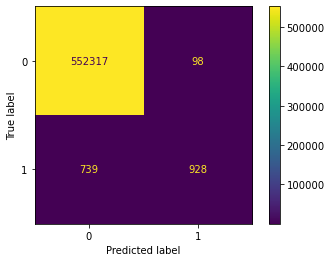

In [20]:
tree_parametré=DecisionTreeClassifier(min_samples_split= 26, min_samples_leaf= 26, max_depth= 10,random_state=0)
test_model(tree_parametré,X_train1, X_test1, y_train1, y_test1)

In [21]:
predictions_simple0=tree_parametré.predict(X_test1)

In [22]:
métriques(predictions_simple0,y_test1)

f1 score= 0.6891942072038619
precision= 0.9044834307992202
recall= 0.5566886622675465


arbre de decision sans optimisation: 

precision= 0.7321729365524986
recall= 0.7822435512897421

On a donc sacrifié du recall pour avoir plus de précision, mais le modèle obtenue ici semble tout de même globalement meilleur

## Test de Hyperopt

On va maintenant utiliser Hyperopt avec les mêmes hyperparamètres dans la grille de recherche pour voir si les résultats sont les mêmes

In [8]:
space = {
    "min_samples_leaf": hp.choice('min_samples_leaf',np.arange(2,32,3)),
    "max_depth": hp.quniform("max_depth", 1, 15,1),
    "min_samples_split":hp.choice("min_samples_split",np.arange(2,32,3))
}

In [9]:
def hyperparameter_tuning(params):
    clf = DecisionTreeClassifier(**params)
    acc = cross_val_score(clf, X_train1, y_train1,scoring="roc_auc").mean()
    return {"loss": -acc, "status": STATUS_OK}

In [15]:
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best))

100%|██████████| 100/100 [4:16:43<00:00, 154.04s/trial, best loss: -0.9859143605321039]  
Best: {'max_depth': 10.0, 'min_samples_leaf': 8, 'min_samples_split': 2}


In [7]:
arbrehyper=DecisionTreeClassifier(max_depth= 10, min_samples_leaf= 8,min_samples_split= 2)

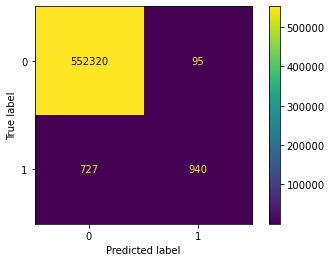

In [8]:
test_model(arbrehyper,X_train1, X_test1, y_train1, y_test1)

In [9]:
predictions_simple_hyper=arbrehyper.predict(X_test1)

In [10]:
métriques(predictions_simple_hyper,y_test1)

f1 score= 0.6957809030347891
precision= 0.9082125603864735
recall= 0.563887222555489


**hyperparamètre du randomgrid: **
    
    'min_samples_split': 26, 'min_samples_leaf': 26, 'max_depth': 10
  
  **hyperparamètre d'hyperopt: ** 
    
    'min_samples_split': 2,  'min_samples_leaf': 8,  'max_depth': 10

Les hyperparamètres 'min_samples_split' et 'min_samples_leaf' sont très différents, 'max_depth' est toujours à 10

Les résultats sont très semblables mais Hyperopt semble se débrouiller légerement mieux. 

Pour expliquer ces résultats on peut faire l'hypothèse que 'min_samples_split' et 'min_samples_leaf' n'ont que très peu d'influence sur les résultats des modèles, contrairement à 'max_depth'. Les deux méthodes ont réussi à trouver le meilleur 'max_depth' mais contrairement à randomgridsearch, hyperopt est capable de savoir dans quelle "direction", il faut faire bouger les paramètres pour avoir les meilleurs scores. Il a donc pu arriver à une meilleur combinaison d'hyperparamètres en moins de 100 tests, là où il en aurait fallu beaucoup plus pour une grille totalement aléatoire


### (test entre les deux)

On essaye rapidements des hyperparamètres intérmédiaires entre ceux obtenues avec l'arbre de decision et cexu obtenues avec Hyperopt:

In [29]:
arbre_entre2=DecisionTreeClassifier(max_depth= 10, min_samples_leaf= 17,min_samples_split= 14)

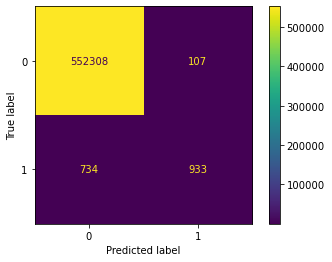

In [30]:
test_model(arbre_entre2,X_train1, X_test1, y_train1, y_test1)

In [32]:
predictions_simple_entre2=arbre_entre2.predict(X_test1)

In [33]:
métriques(predictions_simple_entre2,y_test1)

f1 score= 0.6893239748799409
precision= 0.8971153846153846
recall= 0.5596880623875224


Les résultats sont moins bons, rien de concluant donc

# Hyperopt avec XGBoosting ( sans SMOTE)

Nous allons optimiser nos hyperparamètres XGBoost en limitant la taille de notre trainset (10%) pour éviter que cela mette trop de temps

**création d'un dataset réduit**

In [7]:
fraudes_1=fraudes.copy()
fraudes_réduit=fraudes_1.sample(frac=0.1, random_state=1)

In [8]:
def proprocess_reduit(df):
    df=retirer_transactions(df)  
    df=enlever_colonnes(df)
    df=encoder(df)
    df=scaler(df)

    X_red=df.drop('isFraud',axis=1)
    y_red=df['isFraud']
    
    X_train_red,X_test_red, y_train_red,y_test_red = train_test_split(X_red, y_red, test_size = 0.2, random_state = 15) 
    
    return X_train_red,X_test_red, y_train_red,y_test_red

In [9]:
X_train_red,X_test_red, y_train_red,y_test_red=proprocess_reduit(fraudes_réduit)

Nous allons optimiser nos hyperparamètres par petits groupes, pour éviter que le nombre e combinaisons soit trop élevé et ne fasse explosé le temps d'éxecution:

**optimisation de max_depth et min_child_weight**

In [13]:
space = {
    "max_depth": hp.choice('max_depth',np.arange(3,15,1)),
    'min_child_weight': hp.choice('min_child_weight',np.arange(1,10,1)),
    'learning_rate':hp.choice('learning_rate',np.arange(0.01,0.3,0.04))
                          
        }

In [16]:
def métrique(params):
    xgb_hyper = XGBClassifier(**params,gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27,n_estimators=100)
    xgb_hyper.fit(X_train_red,y_train_red)
    predict=xgb_hyper.predict(X_test_red)
    acc = roc_auc_score(y_test_red,predict)
    return {"loss": -acc, "status": STATUS_OK}

In [ ]:
trials = Trials()

best = fmin(
    fn=métrique,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best))

In [5]:
resultats=pd.DataFrame(trials.trials)
resultats.loc[5,'misc']

NameError: name 'trials' is not defined

**Best: {'learning_rate': 0.1 , 'max_depth': 9, 'min_child_weight': 1}**

**Optimisation du paramètre gamma**

In [ ]:

space2 = {
 'gamma': hp.choice('gamma',[i/10.0 for i in range(0,5)]),
    'subsample': hp.choice('subsample',[i/10.0 for i in range(6,10)]),
 'colsample_bytree': hp.choice('colsample_bytree',[i/10.0 for i in range(6,10)])
}

def métrique2(params):
    xgb_hyper = XGBClassifier(**params, learning_rate =0.1 , max_depth=9,
 min_child_weight=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27,n_estimators=100)
    xgb_hyper.fit(X_train_red,y_train_red)
    predict=xgb_hyper.predict(X_test_red)
    acc = roc_auc_score(y_test_red,predict)
    return {"loss": -acc, "status": STATUS_OK}

trials2 = Trials()

best2 = fmin(
    fn=métrique2,
    space = space2, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials2
)

print("Best: {}".format(best2))

**Best: {'colsample_bytree': 2, 'gamma': 3, 'subsample': 0}**

**reg_alpha**

In [ ]:
space4 = {
 'reg_alpha':hp.choice('reg_alpha',[0.1, 0.2,0.5,0.8,1,1.2,1.5,2,3,5,10,20,50,100])
}

def métrique4(params):
    xgb_hyper = XGBClassifier(**params, learning_rate =0.3, max_depth=9,
 min_child_weight=1,subsample=0.6, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27,n_estimators=100)
    xgb_hyper.fit(X_train_red,y_train_red)
    predict=xgb_hyper.predict(X_test_red)
    acc = roc_auc_score(y_test_red,predict)
    return {"loss": -acc, "status": STATUS_OK}

trials4 = Trials()

best4 = fmin(
    fn=métrique4,
    space = space4, 
    algo=tpe.suggest, 
    max_evals=14, 
    trials=trials4
)

print("Best: {}".format(best4))



**reg alpha (plus précis)**

In [90]:
space5 = {
 'reg_alpha':hp.choice('reg_alpha',[0.1, 0.2,0.5,0.8,1,1.2,1.5,2,3,5,10,20,50,100])
}
def métriqu5(params):
    xgb_hyper = XGBClassifier(**params, learning_rate =, n_estimators=100, max_depth=,
 min_child_weight=1,subsample=0.6, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27,n_estimators=100)
    xgb_hyper.fit(X_train_red,y_train_red)
    predict=xgb_hyper.predict(X_test_red)
    acc = roc_auc_score(y_test_red,predict)
    return {"loss": -acc, "status": STATUS_OK}

trials5 = Trials()

best5 = fmin(
    fn=métrique5,
    space = space5, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials5
)

print("Best: {}".format(best5))


C:\Users\matthias.picard\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:25:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'reg_alpha': 0.8}, 0.996877386749205)

**{'reg_alpha': 0.8},**

**test du modèle**

C:\Users\matthias.picard\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


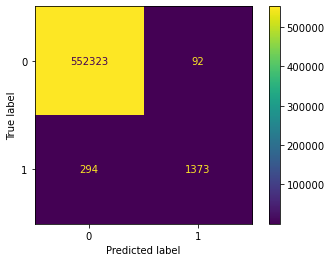

In [36]:
xgb_preprocessé=XGBClassifier( learning_rate =0.4, n_estimators=100, max_depth=9,
 min_child_weight=1, gamma=0.3, subsample=0.6, colsample_bytree=0.8,reg_alpha=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)

test_model(xgb_preprocessé,X_train1,X_test1,y_train1,y_test1)

In [37]:
predictions_xgb_preprocessé=xgb_preprocessé.predict(X_test1)
métriques(predictions_xgb_preprocessé,y_test1)

f1 score= 0.8767560664112387
precision= 0.9372013651877134
recall= 0.823635272945411


de base:

f1 score= 0.872
precision= 0.929
recall= 0.81

learning rate=0,4

f1 score= 0.8767560664112387
precision= 0.9372013651877134
recall= 0.823635272945411

learning rate=0,3

f1 score= 0.8746786632390746
precision= 0.9418685121107266
recall= 0.8164367126574685

learning rate=0,1

f1 score= 0.8384512683578105
precision= 0.945071482317532
recall= 0.7534493101379725

learning rate=0,2

f1 score= 0.8656330749354005
precision= 0.9377186843946816
recall= 0.8038392321535693

In [38]:
results=xgb_preprocessé.predict_proba(X_test1)

In [46]:
seuil=0.015
result_réajusté=(results[:,1]>seuil)

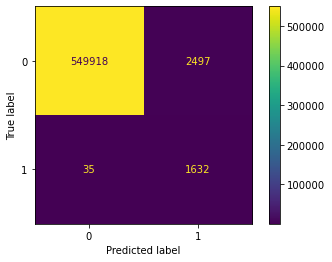

In [47]:
matrice1=confusion_matrix(y_test1,result_réajusté)
ConfusionMatrixDisplay(confusion_matrix=matrice1).plot()

In [48]:
métriques(result_réajusté,y_test1)

f1 score= 0.5631469979296067
precision= 0.39525308791474933
recall= 0.979004199160168


### Optimisation CATBoost

On va faire la même chose avec CATboost

In [51]:
space_cat = {
    "depth": hp.choice('depth',np.arange(3,15,1)),
    'l2_leaf_reg': hp.choice('l2_leaf_reg',np.arange(1,100,1)),
    'learning_rate':hp.choice('learning_rate',np.arange(0.01,0.3,0.04))
                          
        }

In [55]:
np.arange(0.01,0.3,0.04)

array([0.01, 0.05, 0.09, 0.13, 0.17, 0.21, 0.25, 0.29])

In [52]:
def métrique_cat(params):
    xgb_hyper = CatBoostClassifier(**params)
    xgb_hyper.fit(X_train_red,y_train_red)
    predict=xgb_hyper.predict(X_test_red)
    acc = roc_auc_score(y_test_red,predict)
    return {"loss": -acc, "status": STATUS_OK}

In [ ]:
trials_cat = Trials()

best_cat = fmin(
    fn=métrique_cat,
    space = space_cat, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials_cat
)

print("Best: {}".format(best))

In [54]:
print("Best: {}".format(best_cat))

Best: {'depth': 4, 'l2_leaf_reg': 6, 'learning_rate': 6}


In [6]:
cat_modifié=CatBoostClassifier(depth= 6, l2_leaf_reg=7, learning_rate=0.25)

In [ ]:
test_model(cat_modifié,X_train1,X_test1,y_train1,y_test1)

In [8]:
predictions_cat_modifié=cat_modifié.predict(X_test1)
métriques(predictions_cat_modifié,y_test1)

f1 score= 0.8827629911280102
precision= 0.9355271994627267
recall= 0.8356328734253149


sans tuning :

précision:0,931
f1score:0,884
recall:0,842


les résultats sont donc très semblable

**compromis précision/recall**

In [9]:
results_cat=cat_modifié.predict_proba(X_test1)

In [20]:
seuil=0.025
result_réajusté_cat=(results_cat[:,1]>seuil)

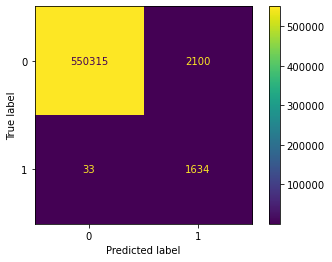

In [21]:
matrice1_cat=confusion_matrix(y_test1,result_réajusté_cat)
ConfusionMatrixDisplay(confusion_matrix=matrice1_cat).plot()

In [22]:
métriques(result_réajusté_cat,y_test1)

f1 score= 0.6050731346047028
precision= 0.4376004284949116
recall= 0.9802039592081584
